In [2]:
from distribution_fit_class import DistributionFit
from portfolio_optimization_class import PortfolioOptimization, optimize_windows
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import glob

In [3]:
copulas = ["clayton_random", "gaussian", "t_student"]
# copulas = ["t_student"]
distributions = ["gauss_dist", "t_dist"]
window_size = 32
taus = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
maximum_weight = 0.3

In [ ]:
# number_of_samples = 10000

#if iter == 2 taus CUT else taus = [...]

for iter in range(1, 11):
    file_path = r'data\random_data\1_stocks_per_sector_' + f'{iter}_iter.csv'
    returns_df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    tau_aggregation = []

    # if iter == 2:
    #     taus = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
    # else:
    #     taus = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]

    for tau_index, tau in enumerate(taus):
        tau_dict = {}
        portfolios = optimize_windows(number_of_quarters=window_size, tau=tau, maximum_weight=maximum_weight, data_path=file_path)
        for copula in copulas:
            absolute_errors_norm = []
            absolute_errors_t = []
            absolute_percentage_errors_norm = []
            absolute_percentage_errors_t = []
            for window in range(0, 64):
                if window % 5 == 0:
                    print(f'Tau: {tau}, Cop: {copula} - {window}')

                returns_window = returns_df.iloc[window : window + window_size - 1]
                distribution_fit = DistributionFit()
                distribution_fit.set_df(returns_window)
                distribution_fit.fit_distribution_all_stocks()

                if iter == 1:
                    simulated_data_path = r'../copulas_outputs/simulated_' + copula + '_11_stocks' + f'_{window}_window.csv'
                else:
                    simulated_data_path = r'../copulas_outputs/simulated_' + copula + '_11_stocks' + f'_{window}_window_{iter}_iter.csv'

                simulated_df = pd.read_csv(simulated_data_path)

                distribution_fit.set_simulated_data_from_df(simulated_df)
                distribution_fit.calculate_returns_from_simulated_quantiles()
                returns_norm = distribution_fit.get_simulated_return_norm()
                returns_t = distribution_fit.get_simulated_return_t_student()

                dist_list = [(returns_t, "t_dist"), (returns_norm, "gauss_dist")]
                for dist_returns, dist_name in dist_list:
                    dist_returns = dist_returns.iloc[:1000]
                    optimizer = PortfolioOptimization()
                    optimizer.set_tau(tau)
                    optimizer.set_maximum_weight(0.3)
                    optimizer.load_simulated_data_from_df(dist_returns)

                    optimizer.build_model()
                    optimizer.solve(verbose=False)
                    evar = optimizer.get_solution_evar()
                    # print(evar)
                    # print(portfolios["EVAR"])
                    theoretical_evar = portfolios.iloc[window]["EVAR"]
                    absolute_error = abs((evar - theoretical_evar))
                    absolute_percentage_error = abs(absolute_error / theoretical_evar) * 100
                    if dist_name == "t_dist":
                        absolute_errors_t.append(absolute_error)
                        absolute_percentage_errors_t.append(absolute_percentage_error)
                    if dist_name == "gauss_dist":
                        absolute_errors_norm.append(absolute_error)
                        absolute_percentage_errors_norm.append(absolute_percentage_error)
            tau_dict[copula+"+t_dist_AE"] = absolute_errors_t
            tau_dict[copula+"+t_dist_APE"] = absolute_percentage_errors_t
            tau_dict[copula+"+gauss_dist_AE"] = absolute_errors_norm
            tau_dict[copula+"+gauss_dist_APE"] = absolute_percentage_errors_norm

        df = pd.DataFrame.from_dict(tau_dict)
        tau_str = str(tau).replace(".", "_")
        # output_path = r"../scores/taus/" + f'tau_{tau_str}/scores_{tau_str}{batch_num}.csv'
        output_path = r"data/errors/" + f'errors_tau_{tau_str}_iter_{iter}.csv'
        df.to_csv(output_path)







Tau: 0.0005, Cop: clayton_random - 0
Tau: 0.0005, Cop: clayton_random - 5
Tau: 0.0005, Cop: clayton_random - 10
Tau: 0.0005, Cop: clayton_random - 15
Tau: 0.0005, Cop: clayton_random - 20
Tau: 0.0005, Cop: clayton_random - 25
Tau: 0.0005, Cop: clayton_random - 30
Tau: 0.0005, Cop: clayton_random - 35

KeyboardInterrupt


DOcplexException: Model<EVaR Optimization> did not solve successfully

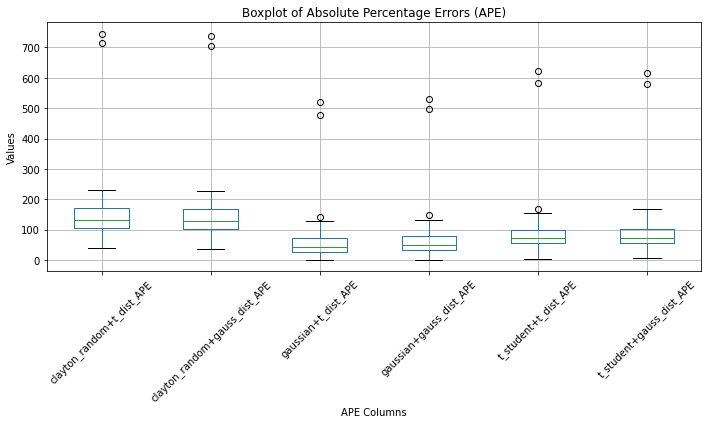

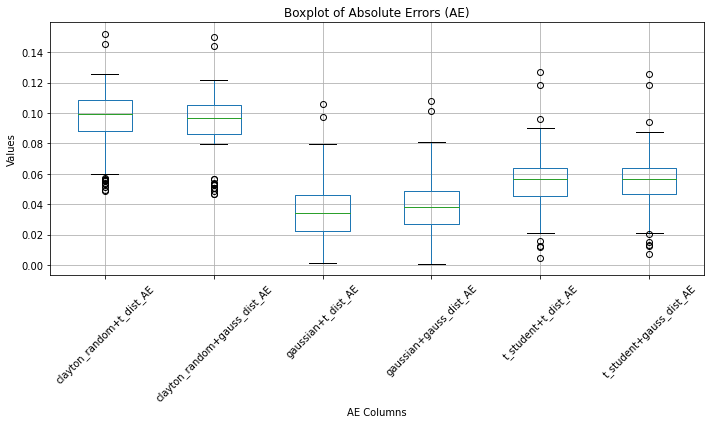

In [9]:
df = pd.read_csv("data/errors/errors_tau_0_001_iter_2.csv", index_col=0)
ape_columns = [col for col in df.columns if 'APE' in col]


plt.figure(figsize=(10, 6))
df[ape_columns].boxplot()
plt.title('Boxplot of Absolute Percentage Errors (APE)')
plt.xlabel('APE Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ae_columns = [col for col in df.columns if 'AE' in col]

plt.figure(figsize=(10, 6))
df[ae_columns].boxplot()
plt.title('Boxplot of Absolute Errors (AE)')
plt.xlabel('AE Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
errors_folder = "data/errors/"


error_files = glob.glob(os.path.join(errors_folder, "errors_tau_*.csv"))

aggregated_data = {}

for file in error_files:
    tau_str = file.split("_tau_")[1].split("_iter")[0].replace("_", ".")
    tau_value = float(tau_str)
    df = pd.read_csv(file, index_col=0)
    means = df.mean(axis=0)
    if tau_value not in aggregated_data:
        aggregated_data[tau_value] = []
    aggregated_data[tau_value].append(means)


final_results = {}

for tau_value, mean_values_list in aggregated_data.items():
    combined_means = pd.concat(mean_values_list, axis=1).mean(axis=1)

    final_results[tau_value] = combined_means

final_df = pd.DataFrame(final_results).T
final_df.sort_index(inplace=True)
final_df.index.name = "Tau"



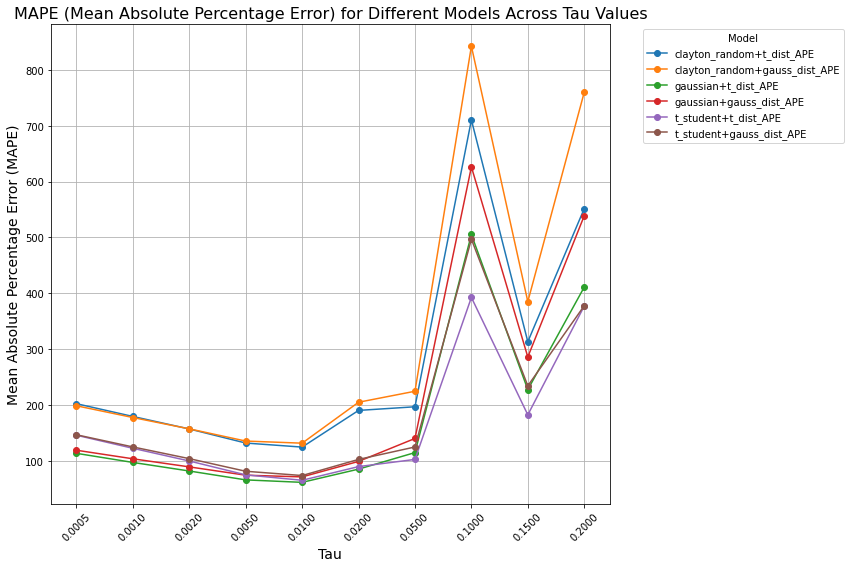

In [22]:
ape_columns = [col for col in final_df.columns if "APE" in col]
df_ape = final_df[ape_columns]

# Plot
plt.figure(figsize=(12, 8))
x_axis = [100*i for i in range(10)]

for col in df_ape.columns:
    plt.plot(x_axis, df_ape[col], marker='o', label=col)

plt.xlabel("Tau", fontsize=14)
plt.ylabel("Mean Absolute Percentage Error (MAPE)", fontsize=14)
plt.title("MAPE (Mean Absolute Percentage Error) for Different Models Across Tau Values", fontsize=16)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(x_axis, labels=[f"{tau:.4f}" for tau in df_ape.index], rotation=45)
plt.grid(visible=True)
plt.tight_layout()

plt.show()

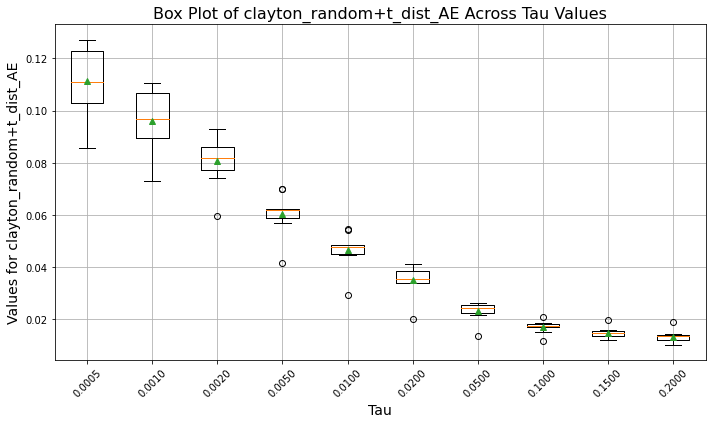

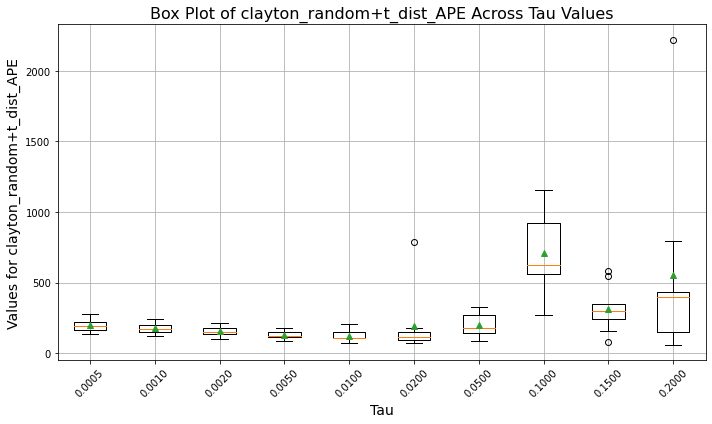

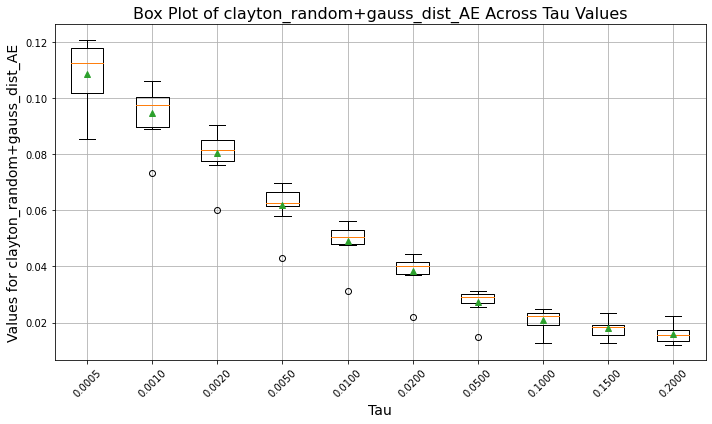

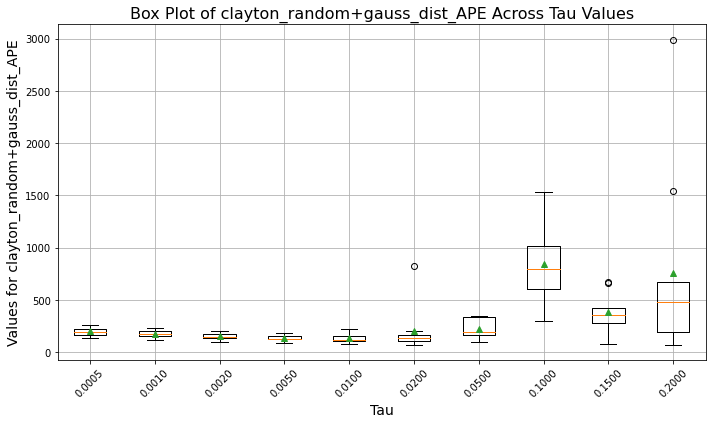

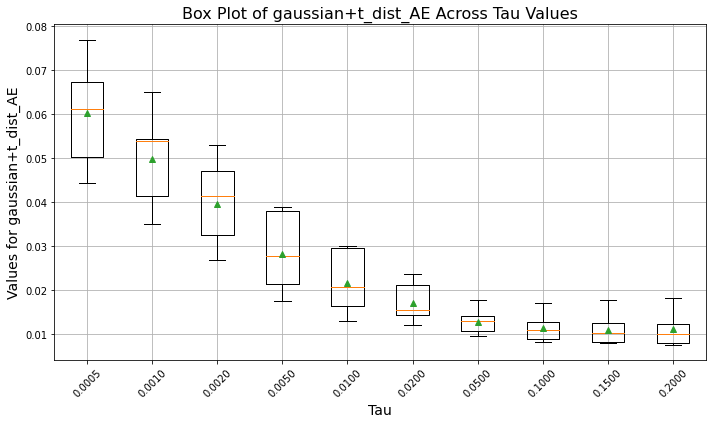

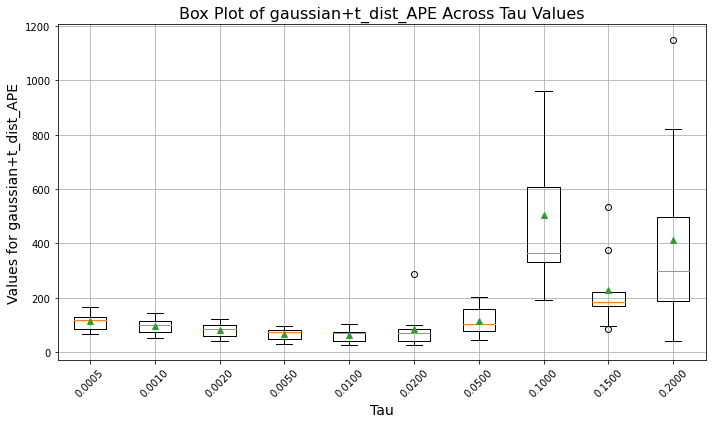

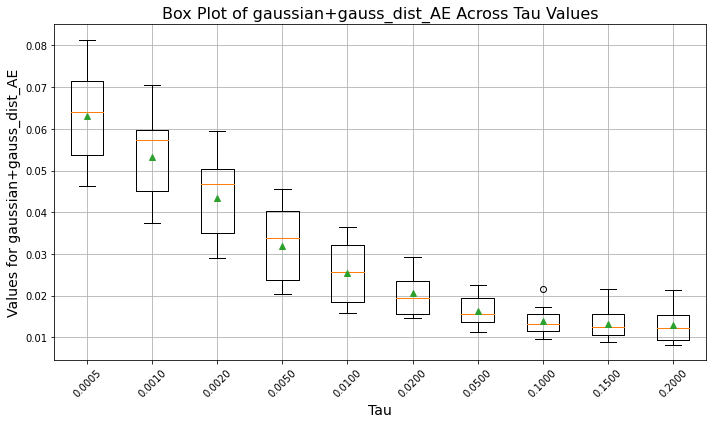

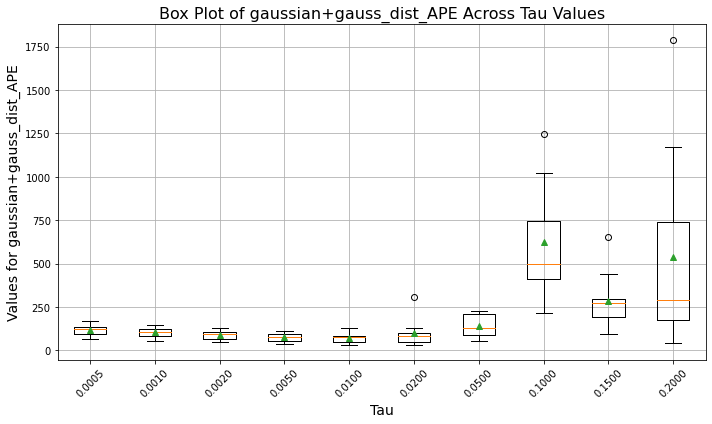

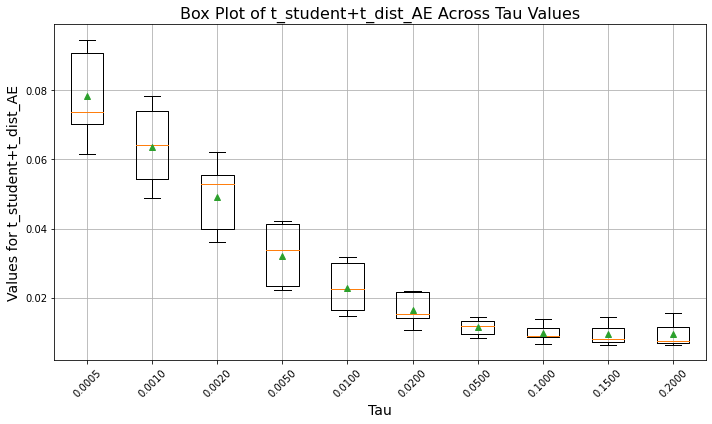

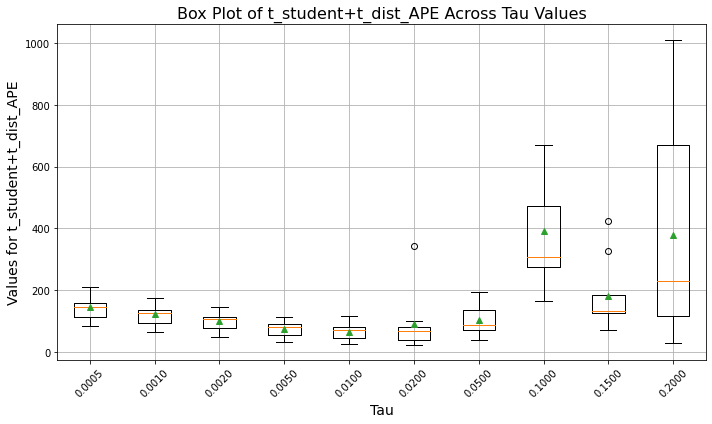

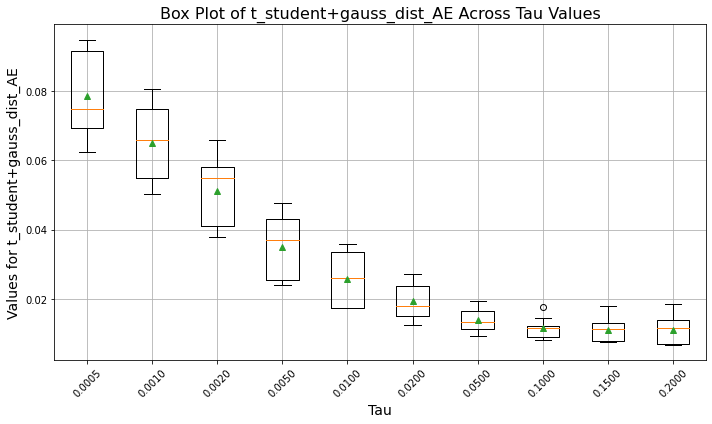

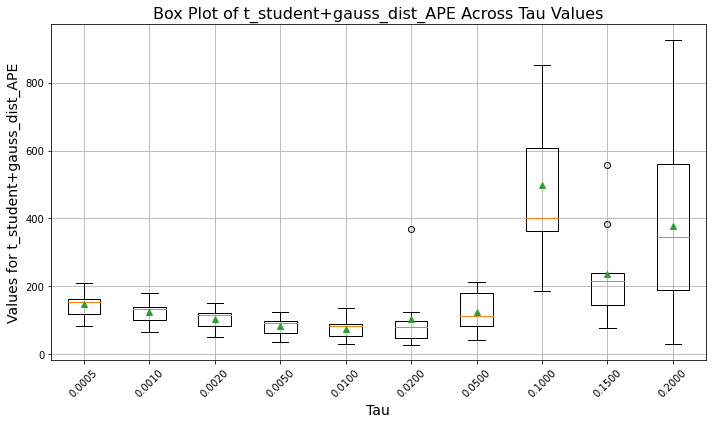

In [50]:
models = aggregated_data[list(aggregated_data.keys())[0]][0].index


for model in models:
    model_data = []
    tau_labels = []

    for tau, portfolios in aggregated_data.items():
        model_values = [portfolio[model] for portfolio in portfolios]
        model_data.append(model_values)
        tau_labels.append(tau)



    sorted_indices = sorted(range(len(tau_labels)), key=lambda k: tau_labels[k])
    tau_labels = [tau_labels[i] for i in sorted_indices]
    model_data = [model_data[i] for i in sorted_indices]



    plt.figure(figsize=(10, 6))
    plt.boxplot(model_data, labels=[f"{tau:.4f}" for tau in tau_labels], showmeans=True)

    plt.title(f"Box Plot of {model} Across Tau Values", fontsize=16)
    plt.xlabel("Tau", fontsize=14)
    plt.ylabel(f"Values for {model}", fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(visible=True)

    plt.tight_layout()
    plt.show()